# Tâche #3 : Classification d'incidents avec des modèles *Transformers*

Toujours avec la même tâche et les mêmes fichiers de textes, utiliser la librairie HuggingFace pour accomplir cette tâche. On demande plus spécifiquement d’utiliser le modèle bert-base-uncased et un autre modèle de votre choix.
Les consignes associées à cette tâche sont:
-	Nom du notebook : transformer.ipynb
-	Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers.
-	Plongements de mots : Ceux du modèle transformer.
-	Normalisation : Lettre en minuscule pour Bert. Aucune contrainte pour le 2e modèle.
-	Choix du 2e transformer: Un modèle encodeur préentraîné pour l’anglais. Le modèle ne doit pas être une autre version de Bert et doit être significativement différent. Utilisez un 2 fichier pour ce modèle si nécessaire (une copie de celui-ci).
-	Analyse : Comparer les résultats obtenus avec les 2 modèles transformers. Présentez également une comparaison globale des résultats obtenus avec tous les modèles utilisés dans ce travail et ceux du travail précédent (TP #1).


Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexe. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code.
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc.
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

In [33]:
!pip install transformers datasets evaluate tensorflow
!pip install transformers[torch]
!pip install matplotlib



## 1. Création du jeu de données (*dataset*)

In [6]:
import pandas as pd
import numpy as np
import json
import os
import torch

from torch import cuda
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, GPT2Tokenizer, GPT2ForSequenceClassification

from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

import evaluate

In [3]:
def load_dataset(filename):
    with open(filename, 'r') as infile:
        content = json.load(infile)
    return [el["text"] for el in content] ,[int(el["label"]) for el in content]

train_dataset_path = "./data/incidents_train.json"
train_texts,train_label = load_dataset(train_dataset_path)
test_dataset_path = "./data/incidents_test.json"
test_texts,test_label  = load_dataset(test_dataset_path)
validation_dataset_path = "./data/incidents_dev.json"
validation_texts,validation_label  = load_dataset(validation_dataset_path)

labels=sorted(set(train_label))
num_labels=len(labels)

In [4]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model_name_2 = "distilgpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(model_name_2)

gpt2_tokenizer.padding_side = "left"
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [5]:
class IncidentDataset(Dataset):
    def __init__(self, text_list, labels, tokenizer, max_length):
        self.text_list = text_list
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, idx):
        text = self.text_list[idx]
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(text, None, add_special_tokens=True, max_length=self.max_length, pad_to_max_length=True, return_token_type_ids=True, truncation=True)

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }


MAX_LEN = 512
train_dataset = IncidentDataset(train_texts, train_label, tokenizer, MAX_LEN)
evaluation_dataset = IncidentDataset(validation_texts, validation_label, tokenizer, MAX_LEN)
test_dataset = IncidentDataset(test_texts,test_label, tokenizer, MAX_LEN)


gpt2_train_dataset = IncidentDataset(train_texts, train_label, gpt2_tokenizer, MAX_LEN)
gpt2_evaluation_dataset = IncidentDataset(validation_texts, validation_label, gpt2_tokenizer, MAX_LEN)
gpt2_test_dataset = IncidentDataset(test_texts,test_label, gpt2_tokenizer, MAX_LEN)


## 2. Création de modèle(s)

In [6]:

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

gpt2_model = GPT2ForSequenceClassification.from_pretrained(model_name_2, num_labels=num_labels)
gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))
gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id # fix model padding token id

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
def create_directory_and_absolute_path(path="./text_classification_transformer/"+model_name):
    if os.path.exists(path):
        print("Directory exists.")
    else:
        print("Directory does not exist.")
        os.makedirs(path, exist_ok=True)
    return os.path.abspath(path)

absolute_path=create_directory_and_absolute_path()
log_absolute_path=create_directory_and_absolute_path("./text_classification_transformer/"+model_name+"/logs")

num_train= 10
training_args = TrainingArguments(
    output_dir=absolute_path,
    logging_dir=log_absolute_path,
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=num_train,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

absolute_path_2=create_directory_and_absolute_path("./text_classification_transformer/"+model_name_2)
log_absolute_path_2=create_directory_and_absolute_path("./text_classification_transformer/"+model_name_2+"/logs")


gpt2_training_args = TrainingArguments(
    output_dir=absolute_path_2,
    logging_dir=log_absolute_path_2,
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=num_train,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)


Directory exists.
Directory exists.
Directory exists.
Directory exists.


In [66]:
device= 'cuda'if cuda.is_available() else 'cpu'
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Entraînement de modèle(s)

In [67]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=evaluation_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

In [69]:
log_bert_train=trainer.train()
#model.cpu()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.198500,1.717227,0.757062
2,0.109900,1.912162,0.768362


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
gpt2_model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=9, bias=False)
)

In [17]:
gpt2_trainer = Trainer(
    model=gpt2_model,
    args=gpt2_training_args,
    train_dataset=gpt2_train_dataset,
    eval_dataset=gpt2_evaluation_dataset,
    compute_metrics=compute_metrics,
)


In [18]:
log_gp2_train = gpt2_trainer.train()
gpt2_model.cpu()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.569400,1.153347,0.632768
2,1.004600,0.853320,0.734463
3,0.768000,0.760319,0.741996
4,0.674100,0.770313,0.755179
5,0.565000,0.768907,0.770245
6,0.497000,0.723571,0.794727
7,0.433100,0.768484,0.779661
8,0.357500,0.988531,0.758945
9,0.294400,0.863810,0.787194
10,0.251600,0.931356,0.775895


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=9, bias=False)
)

## 4. Évaluation et analyse de résultats

In [51]:
model.to(device)
y_test_predict = trainer.predict(test_dataset)

y_test_predict

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


PredictionOutput(predictions=array([[-1.4538453 , -2.184534  ,  6.988407  , ..., -1.2873576 ,
        -0.74030614, -1.1352534 ],
       [ 3.0604973 , -2.068126  , -3.331041  , ..., -1.0640838 ,
         5.6794267 ,  3.89186   ],
       [ 5.7636366 , -0.999136  , -2.838117  , ..., -0.56727666,
         1.3019087 ,  1.7360538 ],
       ...,
       [-1.479135  , -2.2922673 ,  7.0896106 , ..., -0.7555053 ,
        -0.74839574, -1.297685  ],
       [-0.5564115 , -1.6057671 , -0.92029595, ..., -1.5245905 ,
        -1.2287832 , -1.1076746 ],
       [ 1.8373147 , -1.5020835 , -3.3721786 , ..., -0.70529026,
         2.9390092 ,  6.2785745 ]], dtype=float32), label_ids=array([2, 7, 5, 0, 2, 2, 5, 2, 3, 5, 5, 6, 4, 0, 5, 8, 8, 0, 7, 5, 5, 5,
       2, 5, 5, 7, 0, 7, 0, 0, 6, 5, 2, 3, 5, 1, 0, 7, 7, 5, 8, 5, 5, 2,
       0, 0, 3, 2, 5, 2, 5, 8, 5, 5, 5, 2, 5, 8, 3, 7, 7, 3, 5, 5, 5, 5,
       5, 7, 5, 5, 2, 5, 7, 8, 0, 5, 0, 0, 8, 5, 5, 0, 0, 6, 5, 5, 6, 5,
       5, 8, 7, 0, 8, 2, 5, 7, 5, 7, 0, 

In [54]:
log_bert_test=trainer.evaluate(test_dataset)
model.cpu()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [27]:
gpt2_model.to(device)
y_test_predict_gpt2 = gpt2_trainer.predict(gpt2_test_dataset)

y_test_predict_gpt2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


PredictionOutput(predictions=array([[ 1.0317336 , -1.9006817 ,  4.993927  , ...,  0.29879498,
         1.2444777 , -1.1088158 ],
       [ 3.5701945 , -3.0070877 , -2.090904  , ..., -2.9320636 ,
         1.885814  ,  4.1641364 ],
       [ 2.1232357 , -0.19145015,  0.10595976, ..., -3.6798117 ,
        -0.46631962,  1.2529023 ],
       ...,
       [-2.3668687 , -3.2548194 ,  5.1181855 , ...,  4.239284  ,
         0.6596556 , -0.86169195],
       [ 0.41774446, -0.28318352, -0.88724375, ..., -4.9065156 ,
        -3.1452732 ,  0.865372  ],
       [ 4.8751845 , -2.3070586 , -1.6135172 , ..., -2.9033377 ,
         4.095813  ,  2.6825397 ]], dtype=float32), label_ids=array([2, 7, 5, 0, 2, 2, 5, 2, 3, 5, 5, 6, 4, 0, 5, 8, 8, 0, 7, 5, 5, 5,
       2, 5, 5, 7, 0, 7, 0, 0, 6, 5, 2, 3, 5, 1, 0, 7, 7, 5, 8, 5, 5, 2,
       0, 0, 3, 2, 5, 2, 5, 8, 5, 5, 5, 2, 5, 8, 3, 7, 7, 3, 5, 5, 5, 5,
       5, 7, 5, 5, 2, 5, 7, 8, 0, 5, 0, 0, 8, 5, 5, 0, 0, 6, 5, 5, 6, 5,
       5, 8, 7, 0, 8, 2, 5, 7, 5, 7, 0, 

In [37]:
log_gp2_test=gpt2_trainer.evaluate(gpt2_test_dataset)
gpt2_model.cpu()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=9, bias=False)
)

{'test_loss': 0.945525586605072, 'test_accuracy': 0.7269303201506592, 'test_runtime': 12.2561, 'test_samples_per_second': 43.325, 'test_steps_per_second': 2.774}


In [52]:
# Trois objets avec les champs spécifiés
data_objects = [
    y_test_predict[2],
    y_test_predict_gpt2[2]
]

def showModelsResult():
    # Champs à comparer
    fields = ['test_loss', 'test_accuracy', 'test_runtime', 'test_samples_per_second', 'test_steps_per_second']

    # Préparation des données pour le traçage
    data_to_plot = {field: [obj[field] for obj in data_objects] for field in fields}

    # Création du graphique
    fig, axs = plt.subplots(len(fields), figsize=(8, 6))

    # Couleurs différentes pour chaque objet
    colors = [ 'lightcoral', 'lightgreen']

    # Barres avec couleurs différentes et texte en gras pour les valeurs maximales
    for i, field in enumerate(fields):
        for j, obj in enumerate(data_objects):
            bar = axs[i].bar(j, data_to_plot[field][j], color=colors[j])
            axs[i].text(j, data_to_plot[field][j], f'{data_to_plot[field][j]:.2f}', ha='center', va='bottom', fontweight='normal')
            if data_to_plot[field][j] == max(data_to_plot[field]):
                bar[0].set_linewidth(2)  # Augmente l'épaisseur de la barre pour la valeur maximale
                bar[0].set_edgecolor('black')  # Bordure noire pour la valeur maximale
                axs[i].text(j, data_to_plot[field][j], f'{data_to_plot[field][j]:.2f}', ha='center', va='bottom', fontweight='bold')

        axs[i].set_ylabel(field)
        axs[i].set_xticks(range(len(data_objects)))
        axs[i].set_xticklabels([model_name,model_name_2])

    plt.tight_layout()
    plt.show()



Le modèle transformers a été plus difficile à mettre en place car il est beaucoup plus lourd que les modèles des tâches 1 et 2.
En effet comme ce modèle et très lourd et on a du jouer avec les paramètres pour réussir à finir un entrainement, nous avons fait l'entrainement sur Google colab pour pouvoir libérer nos orfinateurs et laisser le colab tourné pendant plusieurs heures.

Cependant nous avons réussi à faire un seul entrainement, voici cependant les paramètres que nous aurions mis si nous avions une machine plus puissante avec plus de mémoire.
HuggingFace déconseille d'augmenter le taux d'apprentissage au dessus de 5e-5 pour le modèle transformers. Comme faire un grand nombre d'epoch n'étais pas possible il n'aurait pas été pertinent de baisser cette valeur. Nous l'avons mis à cette valeur de 5e-5.
Comme précédemment le batch_size doit être le plus grand possible tant que l'ordinateur possède assez de mémoire, dans notre cas le maximum était un batch_size de 4.

Nous n'avons reussi qu'à faire 2 epochs car colab s'arrêtait tout seul lorsqu'il atteint 2 epochs, mais il serait mieux d'en faire plus. Cependant il n'est pas necessaire de beaucoup réentrainer un modèle préentrainé, avec seulement une dixaine d'epochs les résultats aurait été bien meilleur.

Comme second modèle nous avons choisit d'entrainer le modèle GPT2 de google qui est plus léger. Pour avoir une comparaison similaire nous l'avons entrainé avec le même paramètre que bert-base-uncase, c'est a dire avec un taux d'apprentissage de 5e-5 et 4 comme taille de lot.

Voici la courbe d'apprentissage pour le modèle GPT2.

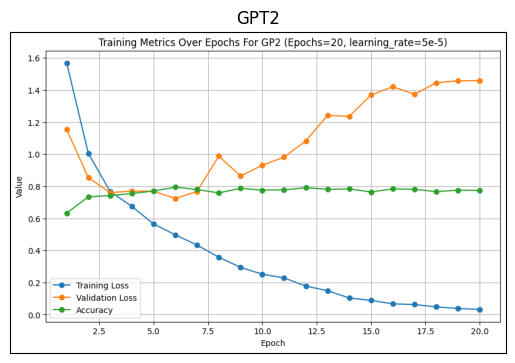

In [8]:
def show(path, title):    
    img = np.asarray(Image.open(path))
    plt.title(title)
    fig = plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

show('./output gpt2 V1.png', 'GPT2')

Comme nous pouvons le constater la perte du jeu de validation augmente ce qui n'est pas vraiment bon signe, cependant la perte sur les données d'apprentissage suit une belle exponentielle décroissante ce qui est encourageant. Peut être que la croissance de la courbe de perte sur les données de validations est dû au fait qu'il y a très peu de données de validation.

Voici à présent un graphique récapitulatif des deux modèles.

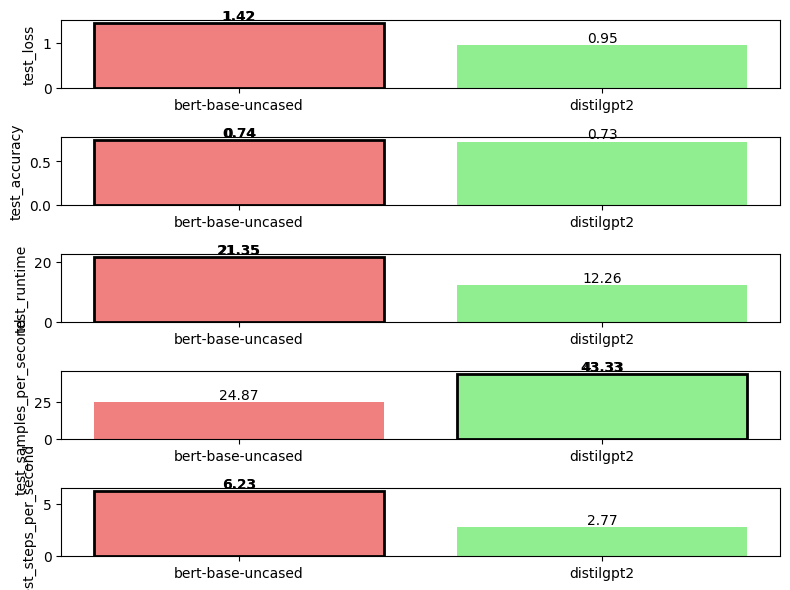

In [53]:
showModelsResult()

On remarque que leurs performances sont très similaire, avec 74% et 73% sur les données de test ces modèles sont plus efficaces que ceux des tâches précedentes bien que plus gros et complexe.
*GPT2* donne vraiment de bon résultat, surtout quand on sais qu'il est bien plus léger que *Bert-Base-Uncase* et qu'on l'a très peu réentrainé.

Nous sommes globalement satisfait de ces résultats bien qu'un entrainement plus profond de ces modèles pouraient donner de bien meilleurs résultats.